In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# The regular version

In [2]:
c = -.2 -.65j
num_iter = 500
N = 500
X0 = np.array([-2, 2, -2, 2])

In [3]:
def julia_set(c, num_iter, N, X0):

    x_min, x_max, y_min, y_max = X0
    x, y = np.ogrid[x_min:x_max:N*1j, y_min:y_max:N*1j]
    z = x + 1j * y
    julia = np.zeros(z.shape)

    for n in range(num_iter):
        z = z**2 + c
        mask = np.abs(z) <= 2
        julia += mask

    return julia

<ipython-input-3-0b5ea2bb9788>:9: RuntimeWarning: overflow encountered in square
  z = z**2 + c
<ipython-input-3-0b5ea2bb9788>:9: RuntimeWarning: invalid value encountered in square
  z = z**2 + c
<ipython-input-3-0b5ea2bb9788>:10: RuntimeWarning: overflow encountered in absolute
  mask = np.abs(z) <= 2


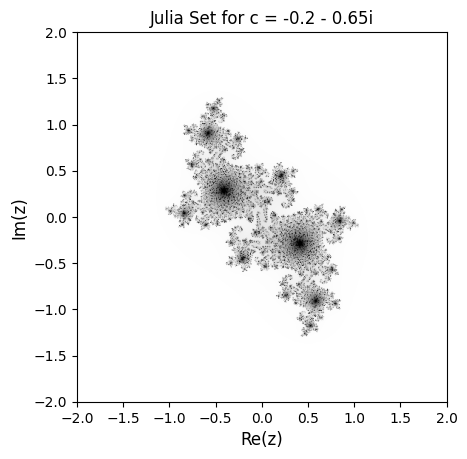

In [4]:
imshow(julia_set(c, num_iter, N, X0),
       extent=(X0[0], X0[1], X0[2], X0[3]), cmap='binary',
       norm=Normalize(vmin=0, vmax=num_iter))
xlabel('Re(z)', fontsize=12)
ylabel('Im(z)', fontsize=12)
title('Julia Set for c = -0.2 - 0.65i')
show()

# Numba-based implementation

In [5]:
from numba import njit

In [6]:
@njit(parallel=True)
def julia_set_numba(c, num_iter, N, X0):
    x_min, x_max, y_min, y_max = X0
    x, y = np.empty((N, N)), np.empty((N, N))

    for i in range(N):
        for j in range(N):
            x[i, j] = x_min + i * (x_max - x_min) / (N - 1)
            y[i, j] = y_min + j * (y_max - y_min) / (N - 1)

    julia = np.zeros((N, N), dtype=np.int32)

    for i in range(N):
        for j in range(N):
            zx = x[i, j]
            zy = y[i, j]
            for n in range(num_iter):
                new_zx = zx * zx - zy * zy + c.real
                new_zy = 2.0 * zx * zy + c.imag
                zx = new_zx
                zy = new_zy
                if zx * zx + zy * zy > 4.0:
                    break
                julia[i, j] = n

    return julia

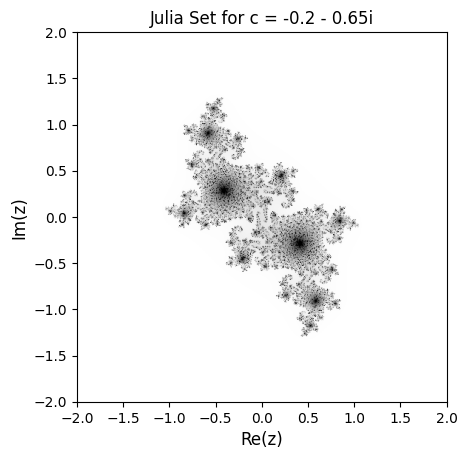

In [7]:
imshow(julia_set_numba(c, num_iter, N, X0),
       extent=(X0[0], X0[1], X0[2], X0[3]), cmap='binary', norm=Normalize(vmin=0, vmax=num_iter))
xlabel('Re(z)', fontsize=12)
ylabel('Im(z)', fontsize=12)
title('Julia Set for c = -0.2 - 0.65i')
show()

# Numba-based implementation comparing with to the regular version

In [8]:
time_jit = %timeit -o julia_set_numba(c, num_iter, N, X0)

30.2 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
time_np = %timeit -o julia_set(c, num_iter, N, X0)

<ipython-input-3-0b5ea2bb9788>:9: RuntimeWarning: overflow encountered in square
  z = z**2 + c
<ipython-input-3-0b5ea2bb9788>:9: RuntimeWarning: invalid value encountered in square
  z = z**2 + c
<ipython-input-3-0b5ea2bb9788>:10: RuntimeWarning: overflow encountered in absolute
  mask = np.abs(z) <= 2


1.99 s ± 390 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
time_jit, time_np

(<TimeitResult : 30.2 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>,
 <TimeitResult : 1.99 s ± 390 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>)

# Numba-based acceleration compared to the regular version

In [11]:
time_np.best/time_jit.best

58.94989770745798

# The graph with performance comparison

In [12]:
import timeit
from timeit import default_timer

In [13]:
num_iter = np.linspace(1, 1000, 30, dtype = np.int32)
np_perf, jit_perf = [], []

In [14]:
for iter in num_iter:
  ### numpy
  start = default_timer()
  julia_set(c, iter, N, X0)
  np_perf.append(default_timer() - start)

  ### numba
  start = default_timer()
  julia_set_numba(c, iter, N, X0)
  jit_perf.append(default_timer() - start)

<ipython-input-3-0b5ea2bb9788>:9: RuntimeWarning: overflow encountered in square
  z = z**2 + c
<ipython-input-3-0b5ea2bb9788>:9: RuntimeWarning: invalid value encountered in square
  z = z**2 + c
<ipython-input-3-0b5ea2bb9788>:10: RuntimeWarning: overflow encountered in absolute
  mask = np.abs(z) <= 2


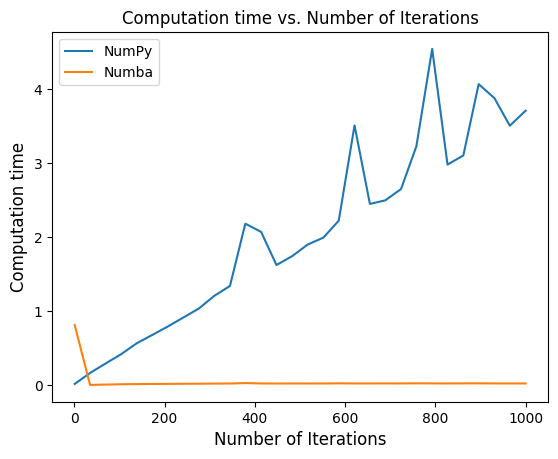

In [15]:
plot(num_iter, np_perf, label="NumPy")
plot(num_iter, jit_perf, label="Numba")
xlabel('Number of Iterations', fontsize=12)
ylabel('Computation time', fontsize=12)
title('Computation time vs. Number of Iterations')
legend()
show()